In [28]:
import matplotlib.pyplot as plt
from proseco.guide import get_guide_catalog

%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [69]:
%run annie-lite.py

## Test case

In [3]:
guides = get_guide_catalog(21068, dither=(20, 20))

In [13]:
np.array(guides.dark).astype(np.float64)

array([[ 101.21461487,   50.11597443,   13.75732708, ...,   71.7346344 ,
         506.0730896 ,  216.18656921],
       [  10.80932808,   14.7399931 ,  220.11723328, ...,   10.80932808,
          23.58398819,   22.60132217],
       [  14.7399931 ,   11.79199409,   13.75732708, ...,   44.21997833,
          26.53198814,   20.63599014],
       ..., 
       [  91.38795471,   30.46265221,  111.04128265, ...,   12.77466011,
          10.80932808,   25.54932022],
       [ 141.50393677,   36.35865021,   13.75732708, ...,  105.14528656,
           8.84399605,   16.70532608],
       [   9.82666206,   39.30664825,   74.68263245, ...,   45.20264435,
          14.7399931 ,  110.05861664]])

In [4]:
guides

id,ra,dec,yang,zang,row,col,mag,mag_err,POS_ERR,PM_RA,PM_DEC,MAG_ACA,MAG_ACA_ERR,CLASS,COLOR1,COLOR1_ERR,VAR,ASPQ1,ASPQ2,ASPQ3,RA_PMCORR,DEC_PMCORR,offchip,imp_mag,imp_r,imp_c,stage,stat_1,stat_2,stat_3,stat_4,stat_5,idx
int32,float64,float64,float64,float64,float64,float64,float32,float64,int16,int16,int16,float32,int16,int16,float32,int16,int16,int16,int16,int16,float64,float64,bool,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64
261489768,195.906179,27.591882,-2071.50,-2184.41,423.63,-437.01,9.62,0.13,28,-12,8,9.62268,7,0,0.9656,5,-9999,0,0,999,195.906179,27.591882,False,11.9495575403,428,-446,4,4,4,4,0,0,0
261492456,195.725550,26.391136,-1504.18,2140.05,310.06,435.71,9.67,0.21,33,-8,16,9.67032,18,0,1.1407,6,-9999,0,0,575,195.725550,26.391136,False,12.0190232857,313,437,4,5,4,4,0,0,1
261490800,195.029470,27.224579,730.39,-861.89,-140.70,-167.62,10.13,0.16,38,-30,14,10.1298,7,0,0.91035,7,-9999,0,0,999,195.029470,27.224579,False,11.7790773748,-149,-163,5,5,5,4,4,0,2
261490688,194.649982,27.195247,1945.88,-762.32,-385.65,-147.76,10.26,0.17,30,-9999,-9999,10.2557,6,0,0.4369,5,-9999,0,0,999,194.649982,27.195247,False,11.7499386426,-390,-148,5,5,5,5,4,0,3


In [67]:
%lprun -f star_track lofi(guides, dt=2.05, n_read=200)

In [73]:
time sdrs = lofi(guides, dt=4.1, n_read=1000)

CPU times: user 315 ms, sys: 2.47 ms, total: 317 ms
Wall time: 316 ms


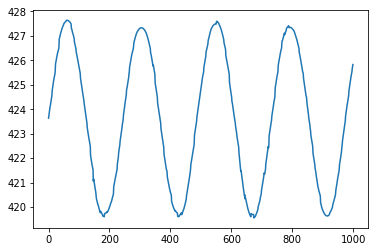

In [74]:
plt.plot(sdrs[0]['cent_row'])

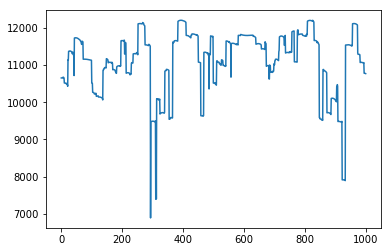

In [10]:
plt.plot(sdrs[0]['norm'])

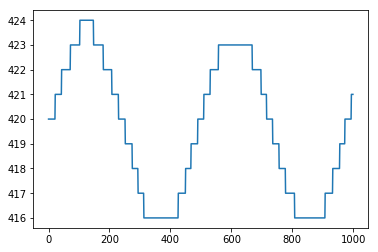

In [11]:
plt.plot(sdrs[0]['img_row0'])

In [54]:
time roll, pitch, yaw = calc_lofi_roll_pitch_yaw(guides, sdrs)

CPU times: user 173 ms, sys: 2.6 ms, total: 176 ms
Wall time: 174 ms


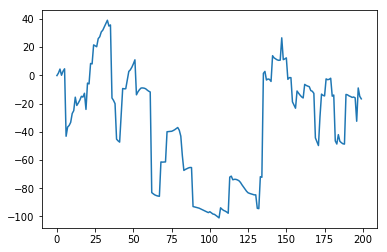

In [10]:
plt.plot(roll)

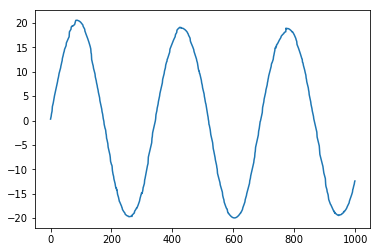

In [15]:
plt.plot(pitch * 3600)

In [24]:
%run annie-lite.py

In [25]:
img = np.zeros((8, 8))
img2 = np.arange(64).reshape(8, 8)
img_row0 = -10
img_col0 = -10
img2_row0 = -8
img2_col0 = -11
add_imgs(img, img_row0, img_col0, img2, img2_row0, img2_col0)
print(img)

[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   2.   3.   4.   5.   6.   7.   0.]
 [  9.  10.  11.  12.  13.  14.  15.   0.]
 [ 17.  18.  19.  20.  21.  22.  23.   0.]
 [ 25.  26.  27.  28.  29.  30.  31.   0.]
 [ 33.  34.  35.  36.  37.  38.  39.   0.]
 [ 41.  42.  43.  44.  45.  46.  47.   0.]]


In [26]:
%timeit add_imgs(img, img_row0, img_col0, img2, img2_row0, img2_col0)


6.65 µs ± 23.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
